# Mathematical Agent with Human in the Loop

In this example, we'll see how to create a mathematical agent with human-in-the-loop functionality for factorial and Fibonacci calculations. The agent will ask for user confirmation **only when computing large values**:
- Factorial: n > 170
- Fibonacci: n > 1000

This demonstrates how to use LangGraph's interrupt mechanism to conditionally pause execution and wait for user approval before proceeding with potentially resource-intensive operations.  
This approval could be used for example when the model want to access a specific web resource and it pause the excecution until the human tells that can continue or you want to consider a more complex workflow for example before let the agent respond to a client request check that is ok before sending an email.

In [1]:
# !pip install langchain-openai==1.1.0
# !pip install langchain==1.1.0
# !pip install langgraph==1.0.4
# !pip install python-dotenv==1.2.1

In [2]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage
from langgraph.types import interrupt
from langgraph.graph import MessagesState
import os

# Load environment variables
load_dotenv()

True

## 3. Configure API Key

Set up the OpenAI API key. Make sure you have your API key in a `.env` file or set it directly.

In [3]:
# Set the OpenAI API key from environment variable
# Make sure you have OPENAI_API_KEY in your .env file or uncomment the line below
# os.environ['OPENAI_API_KEY'] = 'your-api-key-here'

api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print("⚠️ Warning: OPENAI_API_KEY not found in environment variables")
else:
    print("✓ OpenAI API key loaded successfully")

✓ OpenAI API key loaded successfully


## Tool Definitions

We define two mathematical computation tools: `compute_factorial` and `compute_fibonacci`.   
These are similar to the one used in previous tutorial but are removed the if condition in computation for big numbers.

In [4]:
def compute_factorial(n: int) -> dict:
    """Calculates the factorial of a non-negative integer.
    
    Args:
        n (int): The non-negative integer to compute factorial for
        
    Returns:
        dict: Computation status and result
    """
    print(f"🔧 TOOL CALLED: compute_factorial")
    print(f"   INPUT: n = {n}")
    
    if n < 0:
        result = {"status": "error", "error_message": "Factorial is not defined for negative numbers."}
        print(f"   OUTPUT: {result}")
        return result
    
    try:
        factorial_result = 1
        for i in range(2, n + 1):
            factorial_result *= i
        
        result = {"status": "success", "result": f"The factorial of {n} is {factorial_result}"}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": f"Error computing factorial: {str(e)}"}
        print(f"   OUTPUT: {result}")
        return result

def compute_fibonacci(n: int) -> dict:
    """Calculates the nth Fibonacci number (0-indexed).
    
    Args:
        n (int): The position in the Fibonacci sequence (0-indexed)
        
    Returns:
        dict: Computation status and result
    """
    print(f"🔧 TOOL CALLED: compute_fibonacci")
    print(f"   INPUT: n = {n}")
    
    if n < 0:
        result = {"status": "error", "error_message": "Fibonacci is not defined for negative positions."}
        print(f"   OUTPUT: {result}")
        return result
    
    try:
        if n == 0:
            fib_result = 0
        elif n == 1:
            fib_result = 1
        else:
            a, b = 0, 1
            for _ in range(2, n + 1):
                a, b = b, a + b
            fib_result = b
        
        result = {"status": "success", "result": f"The {n}th Fibonacci number is {fib_result}"}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": f"Error computing Fibonacci: {str(e)}"}
        print(f"   OUTPUT: {result}")
        return result

print("✓ Mathematical tools defined successfully")

✓ Mathematical tools defined successfully


## State Definition

The application state is kept minimal and tracks only what we need:
- **`user_approved`**: Boolean flag indicating whether the user approved a tool execution

In this example we use also MessagesState class that stores that is a class that stores 'messages' variable and is provided by langgraph  message.

In [5]:
class State(MessagesState):
    user_approved: bool

## LLM Configuration

We configure the LLM with tool binding using `bind_tools()` to make mathematical tools available.

**Important**: We use `bind_tools()` instead of `create_agent()` because we want manual control over tool execution (for human approval).
To understand better be sure to check also the previous example of this series where we expained how the Agentic tool calling flow works.

In [6]:
from langchain_core.messages import SystemMessage

math_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

# Factorial and Fibonacci tools
math_tools = [compute_factorial, compute_fibonacci]

# System message to guide agent behavior
system_message = SystemMessage(content="""You are a mathematical computation specialist. 
You can calculate factorial and Fibonacci numbers. 
When the user asks for computations, use the appropriate tool:
- For factorial calculations, use `compute_factorial`
- For Fibonacci sequence numbers, use `compute_fibonacci`
""")

# Bind tools to LLM
llm_with_tools = math_llm.bind_tools(math_tools)

print("✓ Math agent configured with factorial and Fibonacci tools")
print("✓ System message defined for better agent behavior")

✓ Math agent configured with factorial and Fibonacci tools
✓ System message defined for better agent behavior


## Agent Node

This agent node calls the LLM to determine what action to take.  
This node does NOT execute tools automatically. It only generates the tool call request, which will then go through the approval process.  
As you can see there is the invocation without iteration. In our cause this is crucial because we have to add a confirmation step after the first invocation.

In [7]:
def agent_node(state: State):
    messages = state["messages"]

    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

## Human Approval Node

This is where incept the approval request! This node:
1. Checks if the agent wants to call a tool
2. Extracts the tool name and arguments
3. Applies conditional logic based on the tool and input value:
   - **Factorial with n > 170**: Requires human approval
   - **Fibonacci with n > 1000**: Requires human approval
   - **All other cases**: Auto-approves and continues

When approval is needed the flow is paused with `interrupt()` and updates the state based on their response.

In [8]:
def human_approval_node(state: State):
    """
    Check if the last message has tool calls and request human approval based on conditions:
    - Factorial: n > 170
    - Fibonacci: n > 1000
    """
    last_message = state["messages"][-1]
    
    # Check if the last message is from AI and has tool calls
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        n_value = tool_args.get("n", 0)
        
        # Determine if approval is needed based on tool and threshold
        needs_approval = False
        threshold_msg = ""
        
        if tool_name == "compute_factorial" and n_value > 170:
            needs_approval = True
            threshold_msg = "n > 170"
        elif tool_name == "compute_fibonacci" and n_value > 1000:
            needs_approval = True
            threshold_msg = "n > 1000"
        
        if needs_approval:
            print(f"\nAPPROVAL REQUIRED FOR LARGE COMPUTATION")
            print(f"Tool: {tool_name}")
            print(f"Arguments: {tool_args}")
            print(f"This computation may be resource-intensive ({threshold_msg})")
            
            approval = interrupt(f"Do you want to proceed with {tool_name}(n={n_value})? "
                 f"This is a large computation. Type 'yes' to approve or 'no' to cancel: ")
            
            if approval and approval.lower() in ["yes", "y"]:
                print("User approved. Proceeding with computation...")
                return {"user_approved": True}
            else:
                print("User denied. Cancelling computation...")
                return {"user_approved": False}
        else:
            # Auto-approve for small values
            print(f"✓ Auto-approved: {tool_name}(n={n_value}) - within safe limits")
            return {"user_approved": True}
    
    return state

print("✓ Human approval node defined")

✓ Human approval node defined


## Conditional Edge Functions

These functions control the workflow routing:

### `should_continue()`
After the agent responds, this function determines the next step:
- If the agent wants to call a tool → go to `human_approval`
- Otherwise → end the conversation

### `after_approval()`
After the human approval check, this function decides:
- If approved (`user_approved == True`) → execute the tool
- If denied (`user_approved == False`) → end without executing tools

In [9]:
def should_continue(state: State):
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "human_approval"

    return END

def after_approval(state: State):
    if state.get("user_approved", False):
        return "tools"
    else:
        return END

## Graph Construction

Now we build the complete workflow graph with the following structure:
1. **Entry point**: User's question goes to the `agent` node
2. **Conditional routing**: After agent response, we check if it wants to call a tool
3. **Approval check**: If yes, go to `human_approval` to check thresholds and get user consent
4. **Tool execution**: If approved, execute the tool and return to agent for final response
5. **Loop closure**: After tool execution, return to agent to formulate the final answer

The `MemorySaver` checkpointer maintains state, allowing the conversation to pause and resume.

In [10]:
from langgraph.prebuilt import ToolNode

# Create tool node that will execute tools
tool_node = ToolNode(math_tools)

# Build the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("human_approval", human_approval_node)
workflow.add_node("tools", tool_node)


# Set up edges
workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue, ["human_approval", END])
workflow.add_conditional_edges("human_approval", after_approval, ["tools", END])
workflow.add_edge("tools", "agent")  # After tools execute, go back to agent to formulate response

# Compile with checkpointer (memory) to manage human-in-the-loop
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

## Visualize the Graph

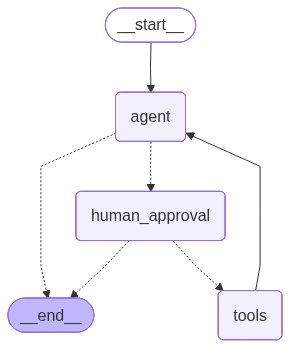

In [11]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Wrong Usage Example

This demonstrates an **incorrect** way to use the graph we have defined. We call `invoke()` directly, which doesn't properly handle the human-in-the-loop mechanism. While this seems to work for auto-approved cases (like factorial of 10), it bypasses the proper streaming flow needed for interrupts when needed.  
We have to use `stream()` with proper interrupt handling.

**Note**: If running the following cell multiple times, change the `thread_id` to avoid conflicts with the conversation memory getting unexpected errors.

In [12]:
config = {"configurable": {"thread_id": "1"}}

user_input = "What is the factorial of 10?"

initial_state = {
    "messages": [system_message, HumanMessage(content=user_input)]
}

print("=" * 60)
print("TEST 1: WRONG CODE: Small Factorial (n=10, auto-approved)")
print("=" * 60)

# Execute the graph directly
result = graph.invoke(initial_state, config)

# Print the final response
final_message = result["messages"][-1]
print(f"\nFinal Answer: {final_message.content}")

TEST 1: WRONG CODE: Small Factorial (n=10, auto-approved)
✓ Auto-approved: compute_factorial(n=10) - within safe limits
🔧 TOOL CALLED: compute_factorial
   INPUT: n = 10
   OUTPUT: {'status': 'success', 'result': 'The factorial of 10 is 3628800'}

Final Answer: 10! = 3,628,800


## Test: Fibonacci with Auto-Approval

This test uses the **correct** approach with `stream()`. Computing the 50th Fibonacci number is well within the safe threshold (n ≤ 1000), so the workflow will automatically approve and execute without requiring user intervention.

**Note**: Change the `thread_id` if running multiple times to avoid continuation of previous conversations.

In [13]:
config_fib_small = {"configurable": {"thread_id": "2"}}

user_input_fib = "Calculate the 50th Fibonacci number"

initial_state_fib = {
    "messages": [system_message, HumanMessage(content=user_input_fib)]
}

print("=" * 60)
print("TEST 2: Small Fibonacci (n=50, auto-approved)")
print("=" * 60)

# First execution - will hit the interrupt
for event in graph.stream(initial_state_fib, config_fib_small, stream_mode="values"):
    if "messages" in event:
        last_msg = event["messages"][-1]

        if isinstance(last_msg, HumanMessage) and last_msg.content:
            print(f"\nUser asked: {last_msg.content}")
        if isinstance(last_msg, ToolMessage) and last_msg.content:
            print(f"\nTool Response: {last_msg.content}")
        if isinstance(last_msg, AIMessage) and last_msg.tool_calls:
            print(f"\nAgent wants to call: {last_msg.tool_calls[0]['name']}(n={last_msg.tool_calls[0]['args']['n']})")
        if isinstance(last_msg, AIMessage) and last_msg.content:
            print(f"\nAgent response: {last_msg.content}")

TEST 2: Small Fibonacci (n=50, auto-approved)

User asked: Calculate the 50th Fibonacci number

Agent wants to call: compute_fibonacci(n=50)
✓ Auto-approved: compute_fibonacci(n=50) - within safe limits

Agent wants to call: compute_fibonacci(n=50)
🔧 TOOL CALLED: compute_fibonacci
   INPUT: n = 50
   OUTPUT: {'status': 'success', 'result': 'The 50th Fibonacci number is 12586269025'}

Tool Response: {"status": "success", "result": "The 50th Fibonacci number is 12586269025"}

Agent response: F(50) = 12586269025


## Test: Large Factorial (n > 170)

This test triggers the human-in-the-loop approval mechanism. Computing factorial of 200 exceeds the threshold (n > 170), so the graph will pause execution and request user confirmation before proceeding with the computation.

In [14]:
config_large_fact = {"configurable": {"thread_id": "3"}}

user_input_large_fact = "What is the factorial of 200?"

initial_state_large_fact = {
    "messages": [system_message, HumanMessage(content=user_input_large_fact)]
}

print("=" * 60)
print("TEST 3: Large Factorial (n=200, requires approval)")
print("=" * 60)

for event in graph.stream(initial_state_large_fact, config_large_fact, stream_mode="values"):
    if "messages" in event:
        last_msg = event["messages"][-1]

        if isinstance(last_msg, HumanMessage) and last_msg.content:
            print(f"\nUser asked: {last_msg.content}")
        if isinstance(last_msg, ToolMessage) and last_msg.content:
            print(f"\nTool Response: {last_msg.content}")
        if isinstance(last_msg, AIMessage) and last_msg.tool_calls:
            print(f"\nAgent wants to call: {last_msg.tool_calls[0]['name']}(n={last_msg.tool_calls[0]['args']['n']})")
        if isinstance(last_msg, AIMessage) and last_msg.content:
            print(f"\nAgent response: {last_msg.content}")

TEST 3: Large Factorial (n=200, requires approval)

User asked: What is the factorial of 200?

Agent wants to call: compute_factorial(n=200)

APPROVAL REQUIRED FOR LARGE COMPUTATION
Tool: compute_factorial
Arguments: {'n': 200}
This computation may be resource-intensive (n > 170)

Agent wants to call: compute_factorial(n=200)


## Resume Execution After Approval

After the graph interrupts and requests confirmation, we can resume execution by streaming with `Command(resume="yes")`. This continues from the paused state and completes the computation.

The graph is currently interrupted inside the `human_approval` node, waiting for user confirmation:

In [15]:
graph.get_state(config_large_fact).next

('human_approval',)

In [16]:
for event in graph.stream(
    Command(resume="yes"),
    config_large_fact,
    stream_mode="values",
):
    # print(event)
    if "messages" in event:
        last_msg = event["messages"][-1]
        
        if isinstance(last_msg, ToolMessage) and last_msg.content:
            print(f"\nTool Response: {last_msg.content}")
        if isinstance(last_msg, AIMessage) and last_msg.content:
            print(f"\nAgent response: {last_msg.content}")


APPROVAL REQUIRED FOR LARGE COMPUTATION
Tool: compute_factorial
Arguments: {'n': 200}
This computation may be resource-intensive (n > 170)
User approved. Proceeding with computation...
🔧 TOOL CALLED: compute_factorial
   INPUT: n = 200
   OUTPUT: {'status': 'success', 'result': 'The factorial of 200 is 788657867364790503552363213932185062295135977687173263294742533244359449963403342920304284011984623904177212138919638830257642790242637105061926624952829931113462857270763317237396988943922445621451664240254033291864131227428294853277524242407573903240321257405579568660226031904170324062351700858796178922222789623703897374720000000000000000000000000000000000000000000000000'}

Tool Response: {"status": "success", "result": "The factorial of 200 is 7886578673647905035523632139321850622951359776871732632947425332443594499634033429203042840119846239041772121389196388302576427902426371050619266249528299311134628572707633172373969889439224456214516642402540332918641312274282948532775242424075

## Test: Large Fibonacci (n > 1000)

This test demonstrates the approval mechanism for Fibonacci calculations. Computing the 1500th Fibonacci number exceeds the threshold (n > 1000), triggering the human-in-the-loop approval process.

In [17]:
config_large_fib = {"configurable": {"thread_id": "4"}}

user_input_large_fib = "What is the Fibonacci of 1500?"

initial_state_large_fib = {
    "messages": [system_message, HumanMessage(content=user_input_large_fib)]
}

print("=" * 60)
print("TEST 4: Large Fibonacci (n=1500, requires approval)")
print("=" * 60)

# First execution - will hit the interrupt
for event in graph.stream(initial_state_large_fib, config_large_fib, stream_mode="values"):
    if "messages" in event:
        last_msg = event["messages"][-1]
        
        if isinstance(last_msg, HumanMessage) and last_msg.content:
            print(f"\nUser asked: {last_msg.content}")
        if isinstance(last_msg, ToolMessage) and last_msg.content:
            print(f"\nTool Response: {last_msg.content}")
        if isinstance(last_msg, AIMessage) and last_msg.tool_calls:
            print(f"\nAgent wants to call: {last_msg.tool_calls[0]['name']}(n={last_msg.tool_calls[0]['args']['n']})")
        if isinstance(last_msg, AIMessage) and last_msg.content:
            print(f"\nAgent response: {last_msg.content}")

TEST 4: Large Fibonacci (n=1500, requires approval)

User asked: What is the Fibonacci of 1500?

Agent wants to call: compute_fibonacci(n=1500)

APPROVAL REQUIRED FOR LARGE COMPUTATION
Tool: compute_fibonacci
Arguments: {'n': 1500}
This computation may be resource-intensive (n > 1000)

Agent wants to call: compute_fibonacci(n=1500)


## Resume Fibonacci Computation

Resume the paused Fibonacci computation by providing user approval:

The graph is currently interrupted inside the `human_approval` node, waiting for user confirmation:

In [18]:
graph.get_state(config_large_fib).next

('human_approval',)

In [19]:
for event in graph.stream(
    # highlight-next-line
    Command(resume="yes"),
    config_large_fib,
    stream_mode="values",
):
    if "messages" in event:
        last_msg = event["messages"][-1]
        
        if isinstance(last_msg, ToolMessage) and last_msg.content:
            print(f"\nTool Response: {last_msg.content}")
        if isinstance(last_msg, AIMessage) and last_msg.content:
            print(f"\nAgent response: {last_msg.content}")


APPROVAL REQUIRED FOR LARGE COMPUTATION
Tool: compute_fibonacci
Arguments: {'n': 1500}
This computation may be resource-intensive (n > 1000)
User approved. Proceeding with computation...
🔧 TOOL CALLED: compute_fibonacci
   INPUT: n = 1500
   OUTPUT: {'status': 'success', 'result': 'The 1500th Fibonacci number is 13551125668563101951636936867148408377786010712418497242133543153221487310873528750612259354035717265300373778814347320257699257082356550045349914102924249595997483982228699287527241931811325095099642447621242200209254439920196960465321438498305345893378932585393381539093549479296194800838145996187122583354898000'}

Tool Response: {"status": "success", "result": "The 1500th Fibonacci number is 135511256685631019516369368671484083777860107124184972421335431532214873108735287506122593540357172653003737788143473202576992570823565500453499141029242495959974839822286992875272419318113250950996424476212422002092544399201969604653214384983053458933789325853933815390935494792961948008